In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import emcee
import corner
from scipy.stats import gaussian_kde
import dynesty
from scipy import integrate
from sklearn import neighbors
from matplotlib.colors import LogNorm
from scipy.special import ndtri

1. 
Download the SPT fgas data from http://iith.ac.in/~shantanud/fgas_spt.txt. 

Fit the data to f0(1 + f1z) where f0 and f1 are unknown constants. Determine the best fit values of f0 and f1 including 68% and 90%

credible intervals using emcee and corner.py . The priors on f0 and f1
should be 0 < f0 < 0.5 and −0.5 < f1 < 0.5. (30 pts)

In [2]:
fgas_data = np.loadtxt('fgas_spt.txt')
z_dat = fgas_data[:,0]
fgas_dat = fgas_data[:,1]
ferr_dat = fgas_data[:,2]


def logprior(theta):
    f0, f1 = theta
    if 0.0 < f0 < 0.5 and -0.5 < f1 < 0.5:
        return 0.0
    return -np.inf

def loglikelihood(theta, z_dat, fgas_dat,ferr_dat):
    f0, f1 = theta
    model = f0*(1  + f1*z_dat)
    sigma2 = ferr_dat**2
    return -0.5*np.sum((fgas_dat-model)**2/sigma2 + np.log(sigma2))

def logposterior(theta, z_dat, fgas_dat, ferr_dat):
    lp = logprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglikelihood(theta, z_dat, fgas_dat, ferr_dat)

ndim = 2
nwalkers = 200
nburn = 1500
nsteps = 2000

pos = np.random.uniform([0.0, -0.5], [0.5, 0.5], size=(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior, args=(z_dat, fgas_dat, ferr_dat))

sampler.run_mcmc(pos, nsteps, progress=True)

samples = sampler.get_chain(discard=nburn, flat=True)




100%|██████████| 2000/2000 [00:06<00:00, 322.50it/s]


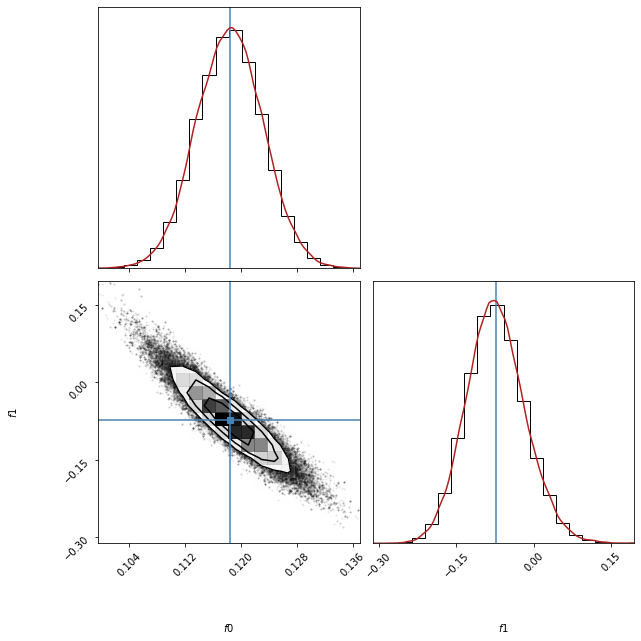

In [13]:
param_mean = [samples[:,0].mean(), samples[:,1].mean()]

def plotposts(samples, **kwargs):
    """
    Function to plot posteriors using corner.py and scipy's gaussian KDE function.
    """
    #if "truths" not in kwargs:
    #    kwargs["truths"] = [f0, b0, logf0]

    fig = corner.corner(samples, labels=[r'$f0$', r'$f1$'], hist_kwargs={'density': True}, **kwargs)
    fig.set_size_inches(10, 10)
    # plot KDE smoothed version of distributions
    for axidx, samps in zip([0, 3], samples.T):
        kde = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick')



#fig = corner.corner(samples, labels=["$f_0$", "$f_1$"],truths=[0.1, 0.1])

plotposts(samples, truths=param_mean)


2. 

Calculate the Bayes factor for the linear and quadratic model for the
example given on fifth blog article of the Pythonic Perambulations Series
using dynesty or Nestle. 

Do the values agree with what’s on the blog
(obtained by integrating the emcee samples).? (30 points)

In [2]:
data = np.array([[ 0.42,  0.72,  0.  ,  0.3 ,  0.15,
                   0.09,  0.19,  0.35,  0.4 ,  0.54,
                   0.42,  0.69,  0.2 ,  0.88,  0.03,
                   0.67,  0.42,  0.56,  0.14,  0.2  ],
                 [ 0.33,  0.41, -0.22,  0.01, -0.05,
                  -0.05, -0.12,  0.26,  0.29,  0.39, 
                   0.31,  0.42, -0.01,  0.58, -0.2 ,
                   0.52,  0.15,  0.32, -0.13, -0.09 ],
                 [ 0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1  ]])
x, y, sigma_y = data

LN2PI = np.log(2. * np.pi)
LNSIGMA = np.log(sigma_y).mean()

In [9]:
def lin_prior_transform(theta):
    m, c = theta
    #mmin, mmax = -100, 100

    #cmin, cmax = -100, 100

    #return (mmin + (mmax - mmin) * m, cmin + (cmax - cmin) * c)

    mmu, msigma = 0.0, 10.0

    cmu, csigma = 0.0, 10.0

    return (mmu + msigma * ndtri(m), cmu + csigma * ndtri(c))


def quadratic_prior_transform(theta):
    a, b, c = theta
    # amin, amax = -100, 100

    # bmin, bmax = -100, 100

    # cmin, cmax = -100, 100

    # return (amin + (amax - amin) * a, bmin + (bmax - bmin) * b,
    #         cmin + (cmax - cmin) * c)

    amu, asigma = 0.0, 10.0

    bmu, bsigma = 0.0, 10.0

    cmu, csigma = 0.0, 10.0

    return (amu + asigma * ndtri(a), bmu + bsigma * ndtri(b), cmu + csigma * ndtri(c))
    

def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    return sum(t * x ** n for (n, t) in enumerate(theta))



M = len(data)
def chisq_likelihood(theta, data=data):
    x, y, sigma_y = data
    yM = polynomial_fit(theta, x)
    norm = -0.5 * M * LN2PI - M * LNSIGMA

    chisq = np.sum((y - yM) ** 2 / sigma_y ** 2)
    return norm - 0.5 * chisq

In [13]:
print("Bayes factor quad/lin = {}".format(np.exp(quad_logZdynesty - lin_logZdynesty)))


print("Bayes factor = {}".format(np.exp(lin_logZdynesty - quad_logZdynesty)))

Bayes factor quad/lin = 0.1284860895364392
Bayes factor = 7.782943691475612


#### $K_{ql} < 1 \implies$ Linear model is preferred

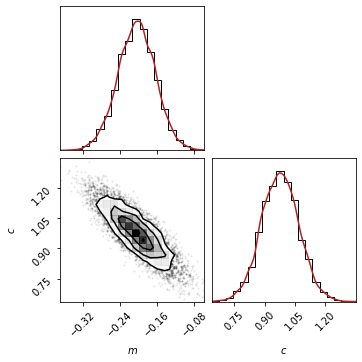

In [17]:
def plotposts(samples, **kwargs):
    

    fig = corner.corner(samples, labels=[r'$m$', r'$c$'], hist_kwargs={'density': True}, **kwargs)

    # plot KDE smoothed version of distributions
    for axidx, samps in zip([0, 3], samples.T):
        kde = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick')

lin_weights = np.exp(lin_res.logwt - lin_res.logz[-1])
lin_samples_dynesty = dynesty.utils.resample_equal(lin_res.samples, lin_weights)

quad_weights = np.exp(quad_res.logwt - quad_res.logz[-1])
quad_samples_dynesty = dynesty.utils.resample_equal(quad_res.samples, quad_weights)

plotposts(lin_samples_dynesty)

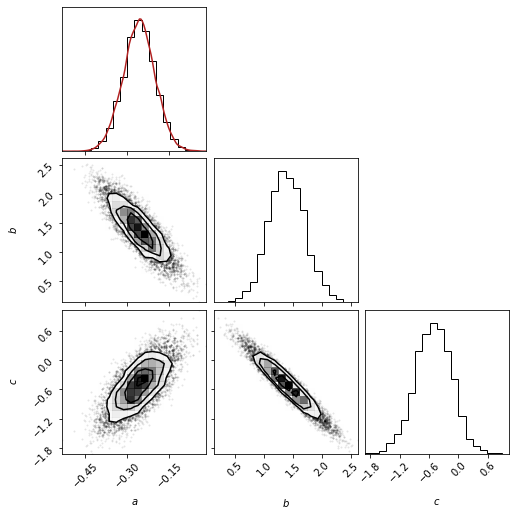

In [18]:
fig = corner.corner(quad_samples_dynesty, labels=[r'$a$', r'$b$', r'$c$'], hist_kwargs={'density': True})

    # plot KDE smoothed version of distributions
for axidx, samps in zip([0, 3], quad_samples_dynesty.T):
    kde = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick')

##### BAYES FACTOR FROM JVDP EMCEE APPROACH = 2.3 in substantial favor with quadratic model

3.
Download the SDSS quasar dataset from http://astrostatistics.psu.edu/datasets/SDSS_quasar.dat. 

Plot the KDE estimate of the quasar redshift distribution (the column with the title z) using a Gaussian and
also an exponential kernel (with bandwidth=0.2) from -0.5 to 5.5. (20
points)

(Hint: Look at the KDE help page in scikit-learn or use the corresponding
functions in astroML module by looking at source code of astroML figures
6.3 and 6.4)

In [19]:
sdss = pd.read_csv('SDSS_quasar.dat', sep='\s+') 
redshift = np.asarray(sdss['z'])
redshift.sort
x_for_redshift = np.linspace(-0.5, 5.5, len(redshift))
X = np.column_stack((x_for_redshift, redshift))
g_kde = neighbors.KernelDensity(bandwidth=0.2, kernel='gaussian').fit(redshift.reshape(-1, 1))
e_kde = neighbors.KernelDensity(bandwidth=0.2, kernel='exponential').fit(redshift.reshape(-1, 1))

In [20]:
g_samp = g_kde.score_samples(redshift.reshape(-1, 1))
e_samp = e_kde.score_samples(redshift.reshape(-1, 1))

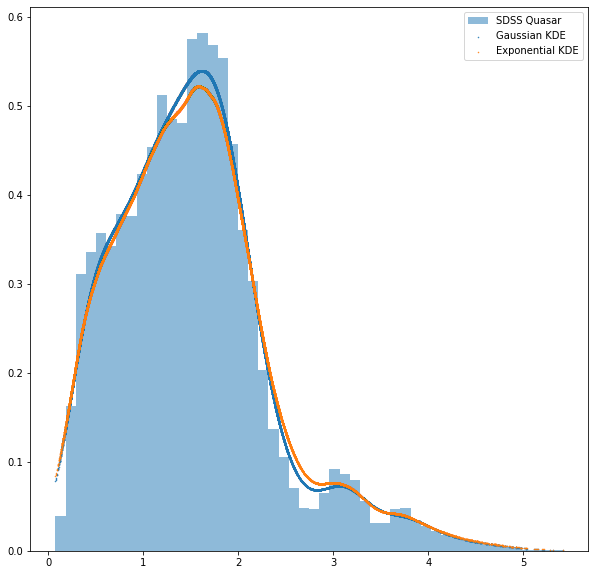

In [27]:
plt.figure(figsize=(10, 10))
plt.hist(redshift, bins=50, density=True, alpha=0.5, label='SDSS Quasar')
plt.scatter(redshift, np.exp(g_samp), label='Gaussian KDE', s=.251)
plt.scatter(redshift, np.exp(e_samp), label='Exponential KDE', s=.251)
plt.legend()
plt.show()